# Creating an interannual monthly photoC that I can save and be able to more easily use in my other figures

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
#import esmlab
import utils
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

In [5]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [6]:
variables = [f'{var}' for var in ['diat1C','diat2C','diat3C', 'ppC', 'diazC', 'mp1C','mp2C','mp3C','mp4C','photoC_TOT']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

import utils
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='100GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=100GB',
        project='P93300070',
        walltime='24:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(32) 

client

In [7]:
%%time

ds_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_annual = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    dsv_annual=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_annual = xr.merge((ds_annual, dsv_annual[vv]))
        

    ds_annual = ds_annual.drop([v for v in ds_annual.variables if v not in keep_vars]).squeeze()
    ds_avg = xr.concat([ds_avg, ds_annual],dim='year',data_vars="different",join="override")

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 14min 30s, sys: 6min 58s, total: 21min 28s
Wall time: 18min 29s


In [8]:
ds_avg.ppC

<xarray.DataArray 'ppC' (year: 62, time: 12, z_t_150m: 15, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(62, 12, 15, 384, 320), dtype=float32, chunksize=(2, 1, 15, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0063-02-01 00:00:00 ... 0064-01-01 00:00:00
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: year, z_t_150m, nlat, nlon
Attributes:
    long_name:     Picoplankton Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [9]:
%%time
# Phytoplankton biomass
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names]
pbmss = xr.concat([ds_avg[v] for v in phyto_vars], dim='var') # units are mmol m-3

CPU times: user 133 ms, sys: 2.03 ms, total: 135 ms
Wall time: 134 ms


In [13]:
pbmss

<xarray.DataArray 'ppC' (var: 9, year: 62, time: 12, z_t_150m: 15, nlat: 384,
                         nlon: 320)>
dask.array<concatenate, shape=(9, 62, 12, 15, 384, 320), dtype=float32, chunksize=(1, 2, 1, 15, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0063-02-01 00:00:00 ... 0064-01-01 00:00:00
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: var, year, z_t_150m, nlat, nlon
Attributes:
    long_name:     Picoplankton Carbon
    units:         mmol/m^3
    grid_loc:      3114
    cell_methods:  time: mean

In [14]:
%time
# Integrate over depth 
pbmss_150m_zint = np.nansum(pbmss,axis=3) * 10/150 #integrate over depth #mmol m-3

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.82 µs


In [15]:
pbmss_150m_zint.shape

(9, 62, 12, 384, 320)

In [16]:
ds_avg.photoC_TOT

<xarray.DataArray 'photoC_TOT' (year: 62, time: 12, z_t_150m: 15, nlat: 384,
                                nlon: 320)>
dask.array<concatenate, shape=(62, 12, 15, 384, 320), dtype=float32, chunksize=(2, 1, 15, 305, 305), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0063-02-01 00:00:00 ... 0064-01-01 00:00:00
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: year, z_t_150m, nlat, nlon
Attributes:
    long_name:     Total C Fixation
    units:         mmol/m^3/s
    grid_loc:      3114
    cell_methods:  time: mean

In [17]:
%time
pbmss_TOT_150m_zint = np.nansum(ds_avg.photoC_TOT,axis=2)*10/150 #integrate over depth #mmol m-3

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [18]:
pbmss_TOT_150m_zint.shape

(62, 12, 384, 320)

In [24]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [27]:
ds.photoC_TOT

<xarray.DataArray 'photoC_TOT' (time: 12, z_t_150m: 15, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(12, 15, 384, 320), dtype=float32, chunksize=(1, 15, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0104-02-01 00:00:00 ... 0105-01-01 00:00:00
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
    ULONG     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Total C Fixation
    units:         mmol/m^3/s
    grid_loc:      3114
    cell_methods:  time: mean

In [23]:
year = np.arange(1948,2010)
year

array([1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009])

In [26]:
%%time
month = np.arange(0,12)
year = np.arange(1948,2010)
names = np.arange(0,9) # Remember that the this is the list: ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
ds_bmss = xr.DataArray(data=pbmss_150m_zint[0,:,:,:,:], coords={'time':year,'month':month,'nlat':ds_avg.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss = ds_bmss.to_dataset(name='ppC_150m_zint')
ds_bmss['diazC'] = xr.DataArray(data=pbmss_150m_zint[1,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp1C'] = xr.DataArray(data=pbmss_150m_zint[2,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat1C'] = xr.DataArray(data=pbmss_150m_zint[3,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp2C'] = xr.DataArray(data=pbmss_150m_zint[4,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat2C'] = xr.DataArray(data=pbmss_150m_zint[5,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp3C'] = xr.DataArray(data=pbmss_150m_zint[6,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['diat3C'] = xr.DataArray(data=pbmss_150m_zint[7,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['mp4C'] = xr.DataArray(data=pbmss_150m_zint[8,:,:,:,:], coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon'])
ds_bmss['photoC_TOT'] = xr.DataArray(data=pbmss_TOT_150m_zint, coords={'time':year,'month':month,'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['time','month','nlat','nlon']) # units mmol/m^3/s
ds_bmss['TLONG']=xr.DataArray(data=ds.TLONG, coords={'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['nlat','nlon'])
ds_bmss['TLAT']=xr.DataArray(data=ds.TLAT, coords={'nlat':ds.nlat, 'nlon':ds.nlon}, 
                           dims=['nlat','nlon'])

CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 26.3 ms


In [29]:
%%time
new_filename_1 = '/glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009/pbmss_ch2_1948_2009.nc'
ds_bmss.to_netcdf(path=new_filename_1)

CPU times: user 58.6 ms, sys: 1.44 s, total: 1.49 s
Wall time: 4.05 s


In [30]:
ds_bmss

<xarray.Dataset>
Dimensions:        (time: 62, month: 12, nlat: 384, nlon: 320)
Coordinates:
  * time           (time) int64 1948 1949 1950 1951 1952 ... 2006 2007 2008 2009
  * month          (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * nlat           (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon           (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
Data variables:
    ppC_150m_zint  (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diazC          (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp1C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat1C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp2C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat2C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp3C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    diat3C         (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mp4C           (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    photoC_TOT     (time, month, nlat, nlon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

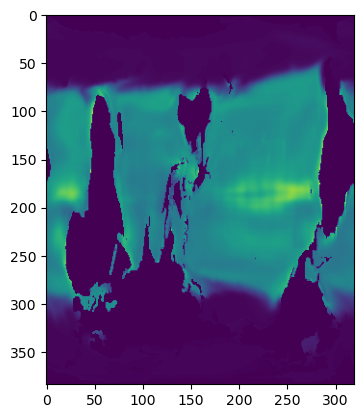

In [32]:
plt.imshow(np.nanmean(ds_bmss.ppC_150m_zint,axis=(0,1)))

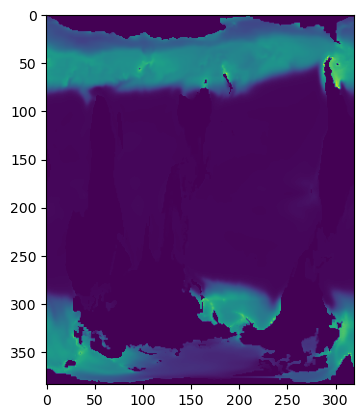

In [33]:
plt.imshow(np.nanmean(ds_bmss.mp1C,axis=(0,1)))

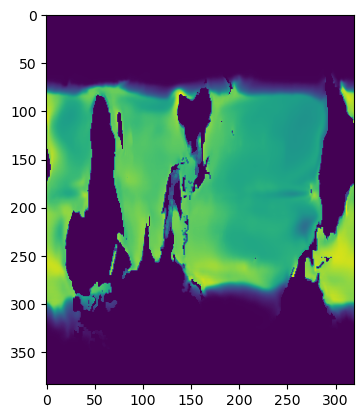

In [34]:
plt.imshow(np.nanmean(ds_bmss.diazC,axis=(0,1)))

# Regrid to 180 by 360 grid

## 3. Regrid from that nc file (you can do this in bash)
module load nco
module load cdo

cd /glade/u/home/gabyn/scratch/SPECTRA/GNG595_monthly_yearly_1948_2009'
# ppC 
ncatted -a coordinates,ppC_150m_zint,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,ppC_150m_zint pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_ppC.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_ppC.nc regrid_pbmss_ch2_1948_2009_ppC.nc

# diatC 
ncatted -a coordinates,diat1C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat1C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_diat1C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_diat1C.nc regrid_pbmss_ch2_1948_2009_diat1C.nc

ncatted -a coordinates,diat2C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat2C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_diat2C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_diat2C.nc regrid_pbmss_ch2_1948_2009_diat2C.nc

ncatted -a coordinates,diat3C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diat3C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_diat3C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_diat3C.nc regrid_pbmss_ch2_1948_2009_diat3C.nc

# mpC
ncatted -a coordinates,mp1C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp1C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_mp1C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_mp1C.nc regrid_pbmss_ch2_1948_2009_mp1C.nc

ncatted -a coordinates,mp2C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp2C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_mp2C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_mp2C.nc regrid_pbmss_ch2_1948_2009_mp2C.nc

ncatted -a coordinates,mp3C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp3C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_mp3C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_mp3C.nc regrid_pbmss_ch2_1948_2009_mp3C.nc

ncatted -a coordinates,mp4C,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,mp4C pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_mp4C.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_mp4C.nc regrid_pbmss_ch2_1948_2009_mp4C.nc

# diazC
ncatted -a coordinates,photoC_TOT,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,photoC_TOT pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_photoC_TOT.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_photoC_TOT.nc regrid_pbmss_ch2_1948_2009_photoC_TOT.nc

# photoC_TOT
ncatted -a coordinates,diazC,c,c,"TLONG TLAT" pbmss_ch2_1948_2009.nc
cdo remapbil,r360x180 -selname,diazC pbmss_ch2_1948_2009.nc pbmss_ch2_1948_2009_diazC.nc
cdo sellonlatbox,-180,180,-89.5,89.5 pbmss_ch2_1948_2009_diazC.nc regrid_pbmss_ch2_1948_2009_diazC.nc

# Upload all of this prior work! 

In [6]:
# Units should be mmol m-3 (averaged through the top 150m)
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/SPECTRA_1990_2009/GNG595_monthly_yearly_1948_2009/regrid/regrid_pbmss_ch2_1948_2009_'
ppC = xr.open_mfdataset(f'{path}ppC.nc') # mmol m-3
mp1C = xr.open_mfdataset(f'{path}mp1C.nc')# mmol m-3
mp2C = xr.open_mfdataset(f'{path}mp2C.nc')# mmol m-3
mp3C = xr.open_mfdataset(f'{path}mp3C.nc')# mmol m-3
mp4C = xr.open_mfdataset(f'{path}mp4C.nc')# mmol m-3
diat1C = xr.open_mfdataset(f'{path}diat1C.nc')# mmol m-3
diat2C = xr.open_mfdataset(f'{path}diat2C.nc')# mmol m-3
diat3C = xr.open_mfdataset(f'{path}diat3C.nc')# mmol m-3
diazC = xr.open_mfdataset(f'{path}diazC.nc')# mmol m-3
photoC_TOT = xr.open_mfdataset(f'{path}photoC_TOT.nc') # units are mmol m-3 s-1

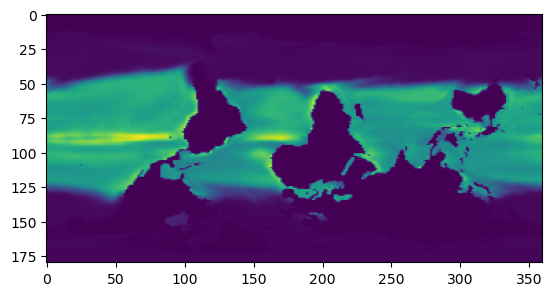

In [12]:
plt.imshow(np.nanmean(ppC.ppC_150m_zint,axis=(0,1)))

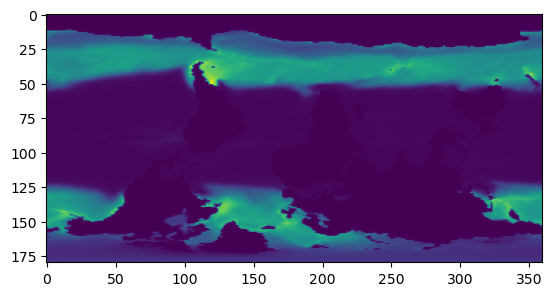

In [13]:
plt.imshow(np.nanmean(mp1C.mp1C,axis=(0,1)))

In [14]:
%%time
bmss = np.stack([ppC.ppC_150m_zint, mp1C.mp1C, diazC.diazC, 
                   mp2C.mp2C, diat1C.diat1C, diat2C.diat2C, 
                   mp3C.mp3C, diat3C.diat3C, mp4C.mp4C])

CPU times: user 752 ms, sys: 2.33 s, total: 3.08 s
Wall time: 5.47 s


In [18]:
bmss_TOT = np.nansum(bmss,axis=0)
print(f' Total phytoplankton biomass summing phytoC in mmol m-3 {np.sum(bmss_TOT)}')
print(f' Total phytoplankton biomass phytoC_TOT in mmol m-3 {np.sum(photoC_TOT.photoC_TOT).values}')

 Total phytoplankton biomass summing phytoC in mmol m-3 28017930.0
 Total phytoplankton biomass phytoC_TOT in mmol m-3 66.54713439941406


## Plot the sum of all phytoplankton biomass over the top 150m

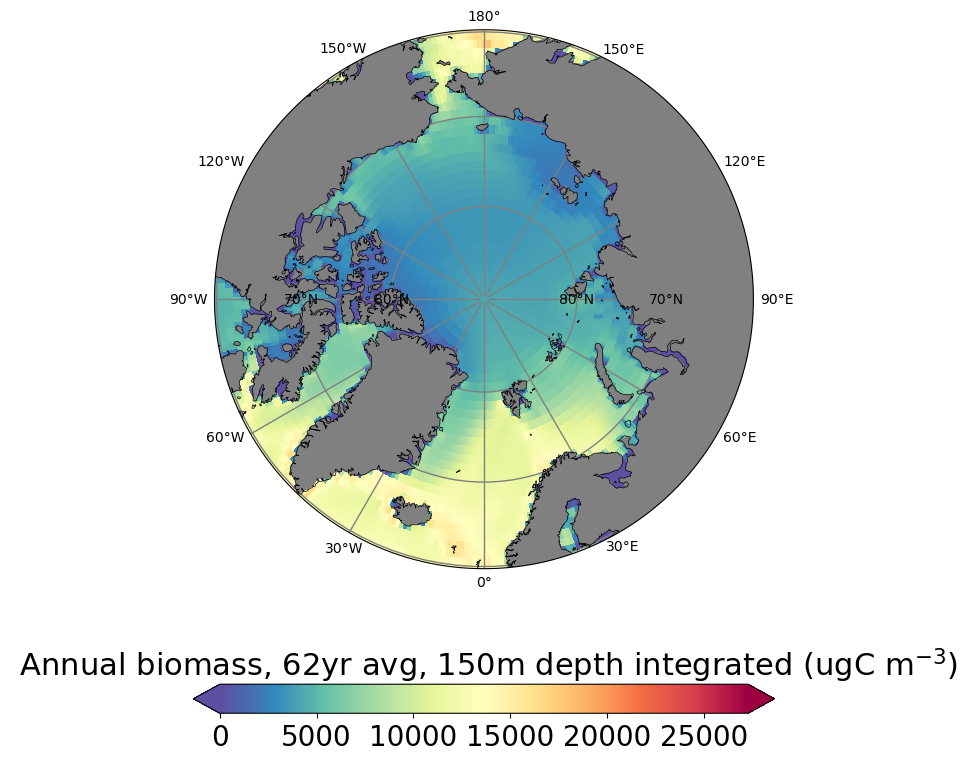

In [22]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
from cartopy.util import add_cyclic_point

r_limit = 3214068.5 #from: ax.get_ylim() of above plot
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=my_projn)
lat = ppC.lat
cold, lon = add_cyclic_point(np.nanmean(bmss_TOT,axis=(0,1))*12.011 *1000, coord=ppC.lon, axis=1)
x, y = np.meshgrid(lon,ppC.lat)
cf = ax.pcolormesh(x,y,cold,cmap='Spectral_r',transform=lonlatproj)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title(' Annual biomass, 62yr avg, 150m depth integrated (ugC m$^{-3}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)
# add bluemarble image
# add coastlines
ax.coastlines(lw=0.5, color="black", zorder=20)


# draw graticule (of meridian and parallel lines)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))


# add extra padding to the plot extents
r_extent = r_limit*1.0001
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())

#set circle boundary
ax.set_boundary(circle_path)

# Plot `photoC_TOT`

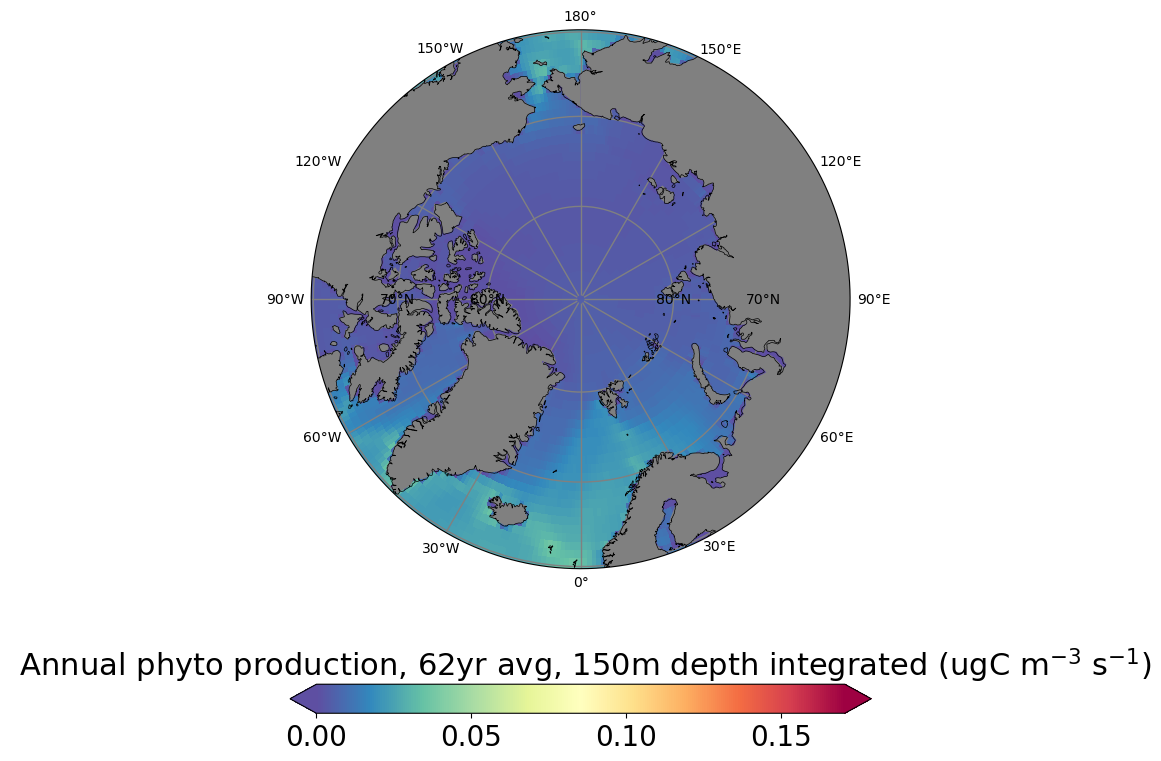

In [28]:
r_limit = 3214068.5 #from: ax.get_ylim() of above plot
lonlatproj = ccrs.PlateCarree()
my_projn = ccrs.Orthographic(central_longitude=0, central_latitude=90)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, projection=my_projn)
lat = ppC.lat
cold, lon = add_cyclic_point(np.nanmean(photoC_TOT.photoC_TOT,axis=(0,1))*12.011 *1000, coord=ppC.lon, axis=1)
x, y = np.meshgrid(lon,ppC.lat)
cf = ax.pcolormesh(x,y,cold,cmap='Spectral_r',transform=lonlatproj)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title(' Annual phyto production, 62yr avg, 150m depth integrated (ugC m$^{-3}$ s$^{-1}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)
# add bluemarble image
# add coastlines
ax.coastlines(lw=0.5, color="black", zorder=20)


# draw graticule (of meridian and parallel lines)
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray",
        y_inline=True, xlocs=range(-180,180,30), ylocs=range(-80,91,10))


# add extra padding to the plot extents
r_extent = r_limit*1.0001
ax.set_xlim(-r_extent, r_extent)
ax.set_ylim(-r_extent, r_extent)

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'));
# Prep circular boundary
circle_path = mpath.Path.unit_circle()
circle_path = mpath.Path(circle_path.vertices.copy() * r_limit,
                           circle_path.codes.copy())

#set circle boundary
ax.set_boundary(circle_path)

In [ ]:
# Old biomass in ugC/-3

Text(0.5, 1.0, '')

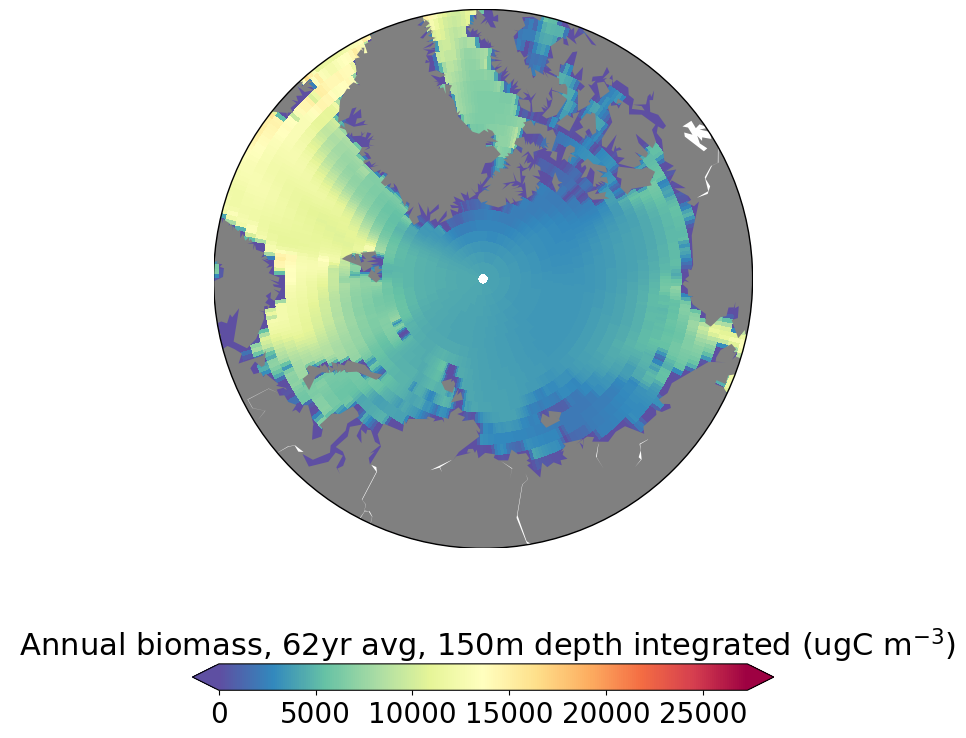

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
lat = ppC.lat
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(np.nanmean(bmss_TOT,axis=(0,1)), coord=ppC.lon, axis=1)
x, y = m(*np.meshgrid(lon,ppC.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title(' Annual biomass, 62yr avg, 150m depth integrated (ugC m$^{-3}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)